# Assembling a Feature Engineering Pipeline with Feature-engine and Cross-validation 
## Titanic competition

In [1]:
import kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [2]:
cols = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
    'Embarked', 'Survived'
]

data = pd.read_csv('../titanic/train.csv', usecols=cols)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [3]:
# # Cabin: extract numerical and categorical part and delete original variable

# data['cabin_num'] = data['Cabin'].str.extract('(\d+)') # captures numerical part
# data['cabin_num'] = data['cabin_num'].astype('float')
# data['cabin_cat'] = data['Cabin'].str[0] # captures the first letter

# data.drop(['Cabin'], axis=1, inplace=True)

In [4]:
# make list of variables types

# numerical: discrete and continuous
discrete = [
    var for var in data.columns if data[var].dtype != 'O' and var != 'Survived'
    and data[var].nunique() < 10
]
continuous = [
    var for var in data.columns
    if data[var].dtype != 'O' and var != 'Survived' and var not in discrete
]

# categorical
categorical = [var for var in data.columns if data[var].dtype == 'O']

print('Variable information before running the pipeline-process:')
print('=========================================================')
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

Variable information before running the pipeline-process:
There are 3 discrete variables
There are 2 continuous variables
There are 3 categorical variables


In [5]:
# separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1),  # predictors
    data['Survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((801, 8), (90, 8))

## Set up Pipeline

In [6]:
# omd

def preprocessing(X):
    
    # Test if X['Cabin'] feature exists
    if 'Cabin' in X.columns:
        # Extract numerical part of 'Cabin' and convert to float
        X['cabin_num'] = X['Cabin'].str.extract('(\d+)')
        X['cabin_num'] = X['cabin_num'].astype('float')
        
        # Extract the first letter of 'Cabin' to create a categorical feature
        X['cabin_cat'] = X['Cabin'].str[0]
        
        # Drop the original 'Cabin' column
        X.drop(['Cabin'], axis=1, inplace=True)
    
    return X

In [7]:
titanic_pipe = Pipeline([

    # omd
    # replace the 'cabin-feature' with a numerical and categorical feature
    ('cabin_features', FunctionTransformer(preprocessing)),
    
    # missing data imputation - section 4
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['Age', 'Fare', 'cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalImputer(variables=['Embarked', 'cabin_cat'])),

    # categorical encoding - section 6
    ('encoder_rare_label',
     ce.RareLabelEncoder(tol=0.01,
                         n_categories=2,
                         variables=['Embarked', 'cabin_cat'])),
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                       variables=['cabin_cat', 'Sex', 'Embarked'])),

    # Gradient Boosted machine
    # ('gbm', GradientBoostingClassifier(random_state=0))
    ('model', XGBClassifier(random_state=0))  # omd
])

## Set up the Grid ad the cross-validation strategy 

In [8]:
# now we create the grid with all the parameters that we would like to test

param_grid = {
    # try different feature engineering parameters
    'imputer_num__arbitrary_number': [-1, 99],
    'encoder_rare_label__tol': [0.1, 0.2],
    'categorical_encoder__encoding_method': ['ordered', 'arbitrary'],
    
    # try different gradient boosted tree model paramenters
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [None, 3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5],
}


# now we set up the grid search with cross-validation
grid_search = GridSearchCV(titanic_pipe, param_grid,
                           cv=5, n_jobs=-1, scoring='roc_auc')

# cv=5 is the cross-validation steps
# no_jobs =-1 indicates to use all available cpus
# scoring='roc-auc' indicates to evaluate the model performance with the roc-auc

# for more details in the grid parameters visit:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [9]:
# and now we train over all the possible combinations of the parameters above
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search: %.3f"
       % grid_search.score(X_train, y_train)))

best roc-auc from grid search: 0.981


In [10]:
# we can print the best estimator parameters like this
grid_search.best_estimator_

Pipeline(steps=[('cabin_features',
                 FunctionTransformer(func=<function preprocessing at 0x7f611865a700>)),
                ('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=99,
                                        variables=['Age', 'Fare',
                                                   'cabin_num'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['Embarked', 'cabin_cat'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=2, tol=0.1,
                                  variables=['Embarke...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

In [11]:
# and find the best fit parameters like this
grid_search.best_params_

{'categorical_encoder__encoding_method': 'arbitrary',
 'encoder_rare_label__tol': 0.1,
 'imputer_num__arbitrary_number': 99,
 'model__colsample_bytree': 1.0,
 'model__gamma': 0.1,
 'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__n_estimators': 100,
 'model__reg_alpha': 0,
 'model__reg_lambda': 0,
 'model__subsample': 0.6}

In [34]:
# omd

# here we can see all the combinations evaluated during the gridsearch
df_grid_search_results = pd.DataFrame(grid_search.cv_results_['params'])
df_grid_search_results['mean_test_score'] = grid_search.cv_results_['mean_test_score']
print(df_grid_search_results.shape)
df_grid_search_results.sort_values(by='mean_test_score', ascending=False, inplace=True).head()

(69984, 12)


,categorical_encoder__encoding_method,encoder_rare_label__tol,imputer_num__arbitrary_number,model__colsample_bytree,model__gamma,model__learning_rate,model__max_depth,model__n_estimators,model__reg_alpha,model__reg_lambda,model__subsample,mean_test_score
51030,arbitrary,0.1,99,1.0,0.1,0.1,5.0,100,0.0,0.0,0.6,0.884255
32670,ordered,0.2,99,1.0,0.0,0.1,7.0,200,0.0,0.0,0.6,0.884060
67662,arbitrary,0.2,99,1.0,0.0,0.1,7.0,200,0.0,0.0,0.6,0.884060
16851,ordered,0.1,99,1.0,0.2,0.1,NaN,100,0.0,0.1,0.6,0.883802
68391,arbitrary,0.2,99,1.0,0.1,0.1,NaN,200,0.0,0.0,0.6,0.883508


In [43]:
# omd

print(f"Best mean_test_score from 5-fold cv = {df_grid_search_results.loc[0,'mean_test_score']:0.4f}")
print(f"grid_search.score(X_train, y_train) = {grid_search.score(X_train, y_train):0.4f}")

Best mean_test_score from 5-fold cv = 0.8665
grid_search.score(X_train, y_train) = 0.9810


In [46]:
# and finally let's check the performance over the test set
print((f"Best performance from grid search = {grid_search.score(X_test, y_test):.4f}"))

Best performance from grid search = 0.8658


<font color="green"># omd</font>

The reason why `grid_search.cv_results_['mean_test_score']` is not the same as `grid_search.score(X_train, y_train)` is because they are measuring different things:

1. **`grid_search.cv_results_['mean_test_score']`**: This provides the mean cross-validated score of the best estimator over all folds. It evaluates the model's performance on validation data (which is unseen during training) across all folds of cross-validation.

2. **`grid_search.score(X_train, y_train)`**: This provides the score of the best estimator on the training data. It evaluates the model's performance on the same data that it was trained on.

The difference in these scores can occur due to various reasons:

- **Overfitting**: If the model is overfitting, it might perform well on the training data but poorly on unseen validation data (leading to a lower cross-validated score).
- **Data Leakage**: If there's any form of data leakage in the preprocessing steps or pipeline, the model might inadvertently learn patterns from the validation data during training, leading to inflated training scores and lower cross-validated scores.
- **Randomness**: Randomness in the splitting of data for cross-validation and the inherent stochasticity of some algorithms can lead to slight variations in scores between the training and validation data.

It's generally expected that the training score will be higher than the cross-validated score due to overfitting. If the training score is significantly higher, it might indicate overfitting or data leakage issues. If you're concerned about overfitting, it's a good practice to rely more on cross-validated scores for assessing model performance.

In [30]:
# # here we can see all the combinations evaluated during the gridsearch
# grid_search.cv_results_['params']

In [31]:
# # and here the scores for each of one of the above combinations
# grid_search.cv_results_['mean_test_score']

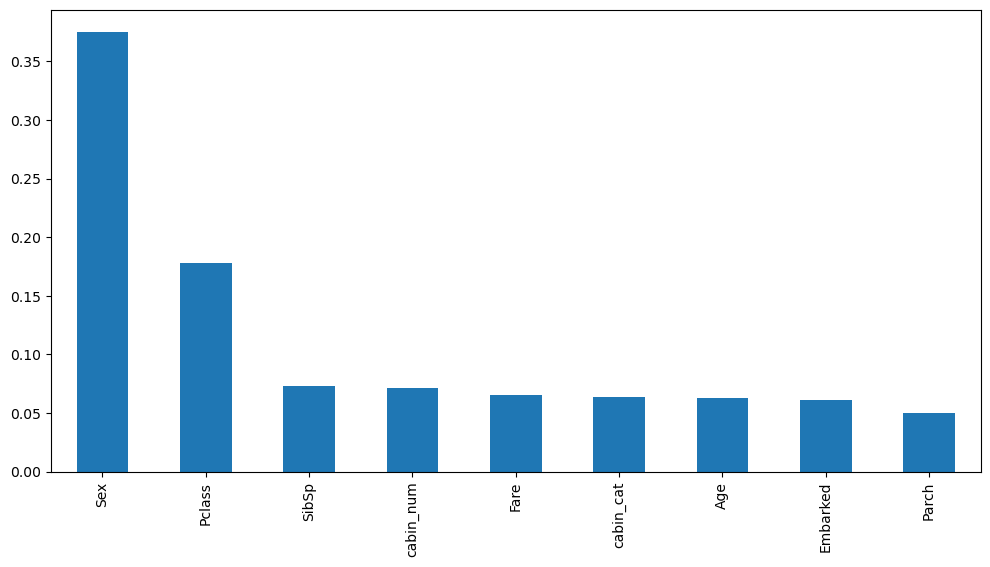

In [23]:
# let's explore the importance of the features

importance = pd.Series(grid_search.best_estimator_['model'].feature_importances_)
# importance.index = data.drop('Survived', axis=1).columns
importance.index = X_train.columns   # omd
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6));

### Serialize the `grid_search` object

In [85]:
# omd

from joblib import dump

# Serialize the GridSearchCV object using joblib:
dump(grid_search, '../titanic/grid_search_results.joblib')

['../titanic/grid_search_results.joblib']

### Deserialize the `grid_search` object

In [86]:
# omd 

from joblib import load

grid_search = load('../titanic/grid_search_results.joblib')

## Create submission.csv file

In [82]:
cols = [
    'PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
    'Embarked'
]

test_submission = pd.read_csv('../titanic/test.csv', usecols=cols)
test_submission.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,male,34.5,0,0,7.8292,NaN,Q
1,893,3,female,47.0,1,0,7.0000,NaN,S
2,894,2,male,62.0,0,0,9.6875,NaN,Q
3,895,3,male,27.0,0,0,8.6625,NaN,S
4,896,3,female,22.0,1,1,12.2875,NaN,S


In [83]:
test_submission['Survived'] = grid_search.predict(test_submission.iloc[:,1:])
test_submission[['PassengerId', 'Survived']].to_csv('../titanic/submission.csv', index=False)
test_submission.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,892,3,male,34.5,0,0,7.8292,NaN,Q,0
1,893,3,female,47.0,1,0,7.0000,NaN,S,0
2,894,2,male,62.0,0,0,9.6875,NaN,Q,0
3,895,3,male,27.0,0,0,8.6625,NaN,S,0
4,896,3,female,22.0,1,1,12.2875,NaN,S,0


In [94]:
# https://www.kaggle.com/competitions/microsoft-malware-prediction/discussion/76245#448176 

# Make a Kaggle submission
kaggle.api.competition_submit(competition='titanic',
                              file_name='../titanic/submission.csv',
                              message=f"classifier = XGBClassifier; features = {grid_search.feature_names_in_.tolist()}; params = {str(grid_search.best_params_)}")

100%|██████████| 2.77k/2.77k [00:00<00:00, 3.92kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster